# CNN Transfer Learning on Cats-Dogs Classification

## CIML Summer Institute, UC San Diego

VGG16 trained on ImageNet data is used as a pre-trained model from which to extract features. Features are then passed through fully connected layers to classify cats vs. dogs.

Adapted from tensorflow tutorials
(https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb)

---



### Setup

In [13]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [14]:
print("Tensorflow version:",tf.__version__)
!python --version
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

Tensorflow version: 2.5.0
Python 3.6.9
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sun Aug  1 08:34:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   33C    P0    41W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------

In [15]:
# Set logging level
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [16]:
# Set random generator seed
seed = 1234

# Disable hash randomization by specifying the value 0.
os.environ['PYTHONHASHSEED'] = '0'

# Set numpy random generator
np.random.seed(seed)

# Set python built-in random generator
random.seed(seed)

# Set tf global random seed
tf.random.set_seed(seed)

# Set tensorflow graph-level random seed
tf.compat.v1.random.set_random_seed(seed)

#potential randomness from CUDNN
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image dimensions, location of images

In [17]:
# Image dimensions
img_width, img_height = 150, 150
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

# Location of images
data_dir = os.getenv('HOME') + '/data/ml/catsVsDogs/'
train_data_dir      = data_dir + 'train'
validation_data_dir = data_dir + 'val'
test_data_dir       = data_dir + 'test'

# Batch size
BATCH_SIZE = 16

### Prepare data

In [18]:
# Data augmentation setup
datagen = ImageDataGenerator(rescale = 1. / 255)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = datagen.flow_from_directory(train_data_dir,target_size=IMG_SIZE,
                                              batch_size = BATCH_SIZE, class_mode='binary', 
                                              shuffle = True, seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = datagen.flow_from_directory(validation_data_dir,target_size=IMG_SIZE,
                                                   batch_size = BATCH_SIZE,class_mode='binary',
                                                   shuffle = False, seed = seed)
# Set up generator to generate batched of test data for model
test_generator = datagen.flow_from_directory(test_data_dir, target_size=IMG_SIZE,
                                             batch_size = BATCH_SIZE, class_mode='binary',
                                             shuffle = False, seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load pre-trained VGG16 model
Pre-trained model is used as feature extractor, so all weights are frozen.

In [19]:
# Load VGG16 model's Imagenet weights not including the top fully connected layers
base_model = applications.VGG16(include_top = False, weights = 'imagenet', 
                                input_shape=IMG_SHAPE)
# Freeze all weights of VGG16 model
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Create top model

Create fully connected layers to put on top of pre-trained VGG16.  

In [20]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### Train model
Train weights in top model

In [21]:
EPOCHS = 20

# Compile model with Adam optimizer with slow learning rate,
# Binary Cross-Entropy loss function and Accuracy metric
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss= losses.BinaryCrossentropy(),metrics=['accuracy'])

# Early Stopping to avoid overfitting and ModelCheckpoint to save the best model
checkpoint_path = 'tmp/checkpoint'
callbacks = [EarlyStopping(monitor='val_loss' ,patience=3, min_delta=0.001, mode='min'),
             ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                             mode = 'min', save_best_only = True, 
                             save_weights_only=True)]

In [22]:
%%time

train_history = model.fit(train_generator,epochs=EPOCHS, 
                          validation_data=validation_generator, 
                          callbacks=callbacks)

Epoch 1/20
125/125 [==============================] - 13s 45ms/step - loss: 0.4551 - accuracy: 0.7780 - val_loss: 0.2816 - val_accuracy: 0.8875
Epoch 2/20
125/125 [==============================] - 5s 41ms/step - loss: 0.2788 - accuracy: 0.8925 - val_loss: 0.2595 - val_accuracy: 0.8800
Epoch 3/20
125/125 [==============================] - 5s 41ms/step - loss: 0.2311 - accuracy: 0.9075 - val_loss: 0.2533 - val_accuracy: 0.8775
Epoch 4/20
125/125 [==============================] - 5s 41ms/step - loss: 0.1930 - accuracy: 0.9235 - val_loss: 0.2443 - val_accuracy: 0.8975
Epoch 5/20
125/125 [==============================] - 5s 41ms/step - loss: 0.1624 - accuracy: 0.9420 - val_loss: 0.2143 - val_accuracy: 0.9150
Epoch 6/20
125/125 [==============================] - 5s 40ms/step - loss: 0.1420 - accuracy: 0.9460 - val_loss: 0.2016 - val_accuracy: 0.9150
Epoch 7/20
125/125 [==============================] - 5s 41ms/step - loss: 0.1207 - accuracy: 0.9590 - val_loss: 0.2109 - val_accuracy: 0.917

In [23]:
# Load the best model that was saved using ModelCheckpoint
model.load_weights(checkpoint_path)

In [24]:
# Save model weights 
model.save("weights_from_feature_extract")

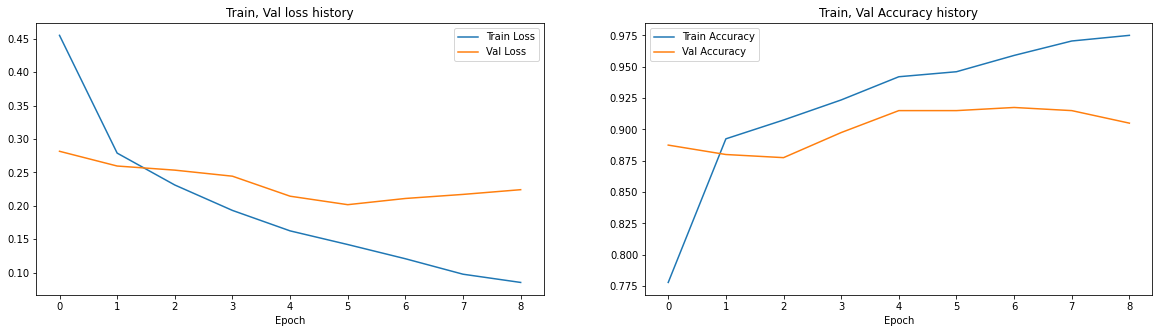

In [25]:
# Plot train and validation history
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluate model

In [26]:
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 4s 34ms/step - loss: 0.0968 - accuracy: 0.9760
Train data accuracy: 0.9760000109672546
25/25 [==============================] - 1s 38ms/step - loss: 0.2501 - accuracy: 0.9050
Test data accuracy: 0.9049999713897705


In [27]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

In [28]:
# Classification report for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs']))

              precision    recall  f1-score   support

        cats       0.89      0.92      0.91       200
        dogs       0.92      0.89      0.90       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.90       400
weighted avg       0.91      0.91      0.90       400



### Perform inference on test images

In [29]:
def image_loader(img_file):
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    img = img_to_array(img) / 255
    img = np.expand_dims(img, axis = 0) #model input is (1,150,150,3)
    return img

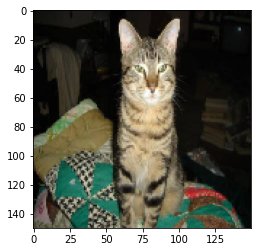

[[0.00512422]]


In [30]:
img = image_loader(data_dir + 'test/cats/cat.1070.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

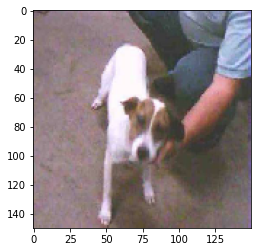

[[0.96226317]]


In [31]:
img = image_loader(data_dir + 'test/dogs/dog.1233.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

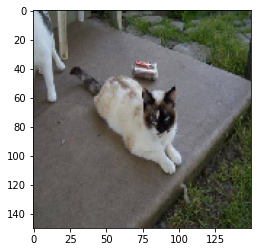

[[0.7235502]]


In [32]:
img = image_loader(data_dir + 'test/cats/cat.1195.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)

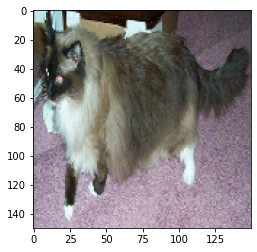

[[0.8573669]]


In [33]:
img = image_loader(data_dir + 'test/cats/cat.1011.jpg')
img_y_pred = model.predict(img) 
print(img_y_pred)